In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from text_clean import *

import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd

analyser = SentimentIntensityAnalyzer()

def label_stocks(row):
    if row['Close'] >= row['yesterday_close']:
        return 1
    else:
        return 0

def label_sentiment(row):
    sent = analyser.polarity_scores(row['text'])
    return pd.Series([sent['neg'], sent['neu'], sent['pos'], sent['compound']])

    

# File paths
apple_stocks = "Data/Stock data/Stocks/aapl.us.txt"
amazon_stocks = "Data/Stock data/Stocks/amzn.us.txt"
facebook_stocks = "Data/Stock data/Stocks/fb.us.txt"

apple_headlines = "Data/News data/apple_deduped.csv"
amazon_headlines = "Data/News data/amazon_deduped.csv"
facebook_headlines = "Data/News data/facebook_deduped.csv"

apple_reddit = "Data/News data/apple_reddit.csv"
amazon_reddit = "Data/News data/amazon_reddit.csv"
facebook_reddit = "Data/News data/facebook_reddit.csv"

apple_tweets = "Data/Tweets/apple_tweets.csv"
amazon_tweets = "Data/Tweets/amazon_tweets.csv"
facebook_tweets = "Data/Tweets/facebook_tweets.csv"

# Twitter date parser
mydateparser = lambda x: pd.datetime.strptime(x[:10] + " " + x[-4:], "%a %b %d %Y")

# Read in text data and stock data
df = pd.read_csv('Data/Tweets/apple_tweets.csv', parse_dates=[1], date_parser=mydateparser)
# df = pd.read_csv(apple_headlines, parse_dates=[1])
df = df.set_index(['Date'])

# Limit to 50 headlines per day
df_new = pd.DataFrame()

for _, group in df.groupby(df.index):
    n = 50 if len(group) >= 50 else len(group)
    df_new = pd.concat([df_new, group.sample(n)])
    
df = df_new

# Use NLTK VADER to add sentiment features
df[['neg', 'neu', 'pos', 'compound']] =  df.apply(label_sentiment, axis=1)

# Read stock in and use yesterday's TI as features
stock = pd.read_csv('aapl_indicators.us.txt', parse_dates=[0])
# stock = ta.add_all_ta_features(stock, 'Open', 'High', 'Low', 'Close', 'Volume', fillna=True)
stock['yesterday_close'] = stock['Close'].shift()
stock['value'] = stock.apply(lambda row: label_stocks(row), axis=1)

stock.loc[:, 'High':'yesterday_close'] = stock.loc[:, 'High':'yesterday_close'].shift()

In [36]:
# Rename twitter columns if necessary
# df.rename({'created_at': 'Date'}, inplace=True, axis=1)
df.drop('user_id_str', axis=1, inplace=True)
df = pd.merge(df, stock, on="Date", how="inner")
df.drop('Close', axis=1, inplace=True)

"""
BALANCE CLASSES
"""
# Class count
count_class_1, count_class_0 = df.value.value_counts()

# Divide by class
df_class_0 = df[df['value'] == 0]
df_class_1 = df[df['value'] == 1]

if count_class_1 > count_class_0:
    df_class_1_under = df_class_1.sample(count_class_0)
    df = pd.concat([df_class_1_under, df_class_0], axis=0)
else:
    df_class_0_under = df_class_0.sample(count_class_1)
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    

df = df.set_index(['Date'])
df.sort_index(inplace=True)

In [37]:
# Scale numeric data
scaler = StandardScaler()
df.loc[:, 'neg': 'yesterday_close'] = scaler.fit_transform(df.loc[:, 'neg': 'yesterday_close'])

In [14]:
df

,text,neg,neu,pos,compound,Open,High,Low,Volume,volume_adi,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,yesterday_close,value
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-27,Apple Mac Pro finally on sale,-0.491720,0.787165,-0.554147,-0.085498,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1
2014-01-27,U.S. urges court to let Apple antitrust monito...,-0.491720,0.787165,-0.554147,-0.085498,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1
2014-01-27,Apple to venture into mobile-payments business,-0.491720,0.787165,-0.554147,-0.085498,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1
2014-01-27,Apple earnings cap off Monday s 5 things,-0.491720,0.787165,-0.554147,-0.085498,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1
2014-01-27,Watch Steve Jobs demo the first Apple Mac back...,-0.491720,0.787165,-0.554147,-0.085498,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1
2014-01-27,Glass House + Stone (or Something) = Apple Sto...,2.522925,-1.391912,-0.554147,-2.382671,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1
2014-01-27,Apple a no-brainer on earnings?,-0.491720,0.787165,-0.554147,-0.085498,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1
2014-01-27,"Icahn raises Apple stake, now owns $3bn in stock",-0.491720,0.787165,-0.554147,-0.085498,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1
2014-01-27,Apple engineers who brought Mac to life get r...,-0.491720,0.787165,-0.554147,-0.085498,-1.920161,-1.919399,-1.923016,1.758840,0.194778,...,-0.121609,-0.191086,0.406933,-0.191086,-0.463996,-1.118941,-1.119646,-1.956352,-1.863196,1


Preprocess and split data into train and test sets

In [38]:
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x.loc[:, 'neg': 'yesterday_close'], validate=False)

# df['text'] = df['text'].str.replace('[^\w\s]',' ')

# X = features, y = class labels
X = df.loc[:, 'text': 'yesterday_close']
y = df.loc[:, 'value']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Avoid having same days in train and test set
# X_train, y_train = X.loc[:'2015-07-26'], y.loc[:'2015-07-26']
# X_test, y_test = X.loc['2015-07-26':], y.loc['2015-07-26':]

In [39]:
# Create model and vectorizer
vect = TfidfVectorizer(analyzer='word', stop_words='english', strip_accents='unicode', ngram_range=(1, 3), max_features=500)

model = Pipeline([
    ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data)
                ])),
#                   ('text_features', Pipeline([
#                      ('selector', get_text_data),
#                      ('vec',  vect)
#                  ]))
         ])),
    ('clf', LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=False, loss='hinge', penalty='l2', random_state=42))
    #('clf', KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute')),
    # ('clf', LinearSVC(class_weight='balanced', fit_intercept=False, penalty='l1', dual=False, C=0.2)),
])

# model.fit(X_train, y_train)
# print(model.score(X_train, y_train))
# y_pred = model.predict(X_test)


# print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
# print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

In [20]:
X_cv = X.reset_index()
y_cv = y.reset_index()
cv_iterator = []
# Cross Validation
kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X):
    # Calculate train date range
    train_date_begin = df.index[train_index[0]]
    train_date_end = df.index[train_index[-1]]
    train_date_begin = str(train_date_begin.date())
    train_date_end = str(train_date_end.date())
    
    # Calculate test date range
    test_date_begin = df.index[test_index[0]]
    test_date_end = df.index[test_index[-1]]
    test_date_begin = str(test_date_begin.date())
    test_date_end = str(test_date_end.date())
    
    # Split
    mask_train = ((X_cv['Date'] >= train_date_begin) & (X_cv['Date'] < test_date_begin)) | ((X_cv['Date'] > test_date_end) & (X_cv['Date'] <= train_date_end))
    mask_test = (X_cv['Date'] >= test_date_begin) & (X_cv['Date'] <= test_date_end)
    train_indices = X_cv.loc[mask_train].index.values
    test_indices = X_cv.loc[mask_test].index.values
    cv_iterator.append((train_indices, test_indices))


In [83]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'features', 'clf', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__numeric_features', 'features__text_features', 'features__numeric_features__memory', 'features__numeric_features__steps', 'features__numeric_features__selector', 'features__numeric_features__selector__accept_sparse', 'features__numeric_features__selector__check_inverse', 'features__numeric_features__selector__func', 'features__numeric_features__selector__inv_kw_args', 'features__numeric_features__selector__inverse_func', 'features__numeric_features__selector__kw_args', 'features__numeric_features__selector__pass_y', 'features__numeric_features__selector__validate', 'features__text_features__memory', 'features__text_features__steps', 'features__text_features__selector', 'features__text_features__vec', 'features__text_features__selector__accept_sparse', 'features__text_features__selector__check_inverse', 'features__text_features__selector__func', '

In [26]:
# Choose some parameter combinations to try
parameters = {'clf__penalty': ['l1', 'l2'], 
              'clf__loss': ['hinge', 'squared_hinge'], 
              'clf__dual': [True, False],
              'clf__C': [0.1, 1, 2, 10, 100], 
              'clf__fit_intercept': [False],
              'clf__random_state': [None, 42],
              'clf__max_iter': [1000, 2000, 3000]
             }

# parameters = {'features__text_features__vec__analyzer': ['word', preprocess_text], 
#               'features__text_features__vec__ngram_range': [(1, 1), (1, 2), (1, 3), (3, 3)]
#              }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(model, parameters, scoring=acc_scorer, n_jobs=-1, error_score=0.0, cv=cv_iterator, verbose=10)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

Fitting 2 folds for each of 240 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1419s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.2421s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1929s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1439s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Batch computation too slow (5.9179s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.6274s.) Setting batch_

In [29]:
grid_obj.best_params_

{'clf__C': 0.1,
 'clf__dual': False,
 'clf__fit_intercept': False,
 'clf__loss': 'squared_hinge',
 'clf__max_iter': 3000,
 'clf__penalty': 'l1',
 'clf__random_state': 42}

# Cross-validate model

In [40]:
accs = []
f1s = []
cms = []

X_cv = X.reset_index()
y_cv = y.reset_index()
# try:
#     model = clf
# except:
#     pass

# Cross Validation
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    # Calculate train date range
    train_date_begin = df.index[train_index[0]]
    train_date_end = df.index[train_index[-1]]
    train_date_begin = str(train_date_begin.date())
    train_date_end = str(train_date_end.date())
    print(train_index)
    print(test_index)
    # Calculate test date range
    test_date_begin = df.index[test_index[0]]
    test_train_left = test_date_begin - pd.DateOffset(1)
    
    test_date_end = df.index[test_index[-1]]
    test_train_right = test_date_end + pd.DateOffset(1)
    
    test_date_begin = str(test_date_begin.date())
    test_date_end = str(test_date_end.date())
    
    # Split
    #X_train, X_test = pd.concat([X.loc[train_date_begin:test_train_left], X.loc[test_train_right:train_date_end]]), X.loc[test_date_begin:test_date_end]
    #y_train, y_test = pd.concat([y.loc[train_date_begin:test_train_left], y.loc[test_train_right:train_date_end]]), y.loc[test_date_begin:test_date_end]
    mask_train = ((X_cv['Date'] >= train_date_begin) & (X_cv['Date'] < test_date_begin)) | ((X_cv['Date'] > test_date_end) & (X_cv['Date'] <= train_date_end))
    mask_test = (X_cv['Date'] >= test_date_begin) & (X_cv['Date'] <= test_date_end)
    X_train, X_test = X_cv.loc[mask_train].loc[:, 'text':], X_cv.loc[mask_test].loc[:, 'text':]
    y_train, y_test = y_cv.loc[mask_train]['value'], y_cv.loc[mask_test]['value']
    
    model.fit(X_train, y_train)
    print(model.score(X_train, y_train))
    y_pred = model.predict(X_test)
    
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))

# print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
# print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

[ 1082  1083  1084 ... 10815 10816 10817]
[   0    1    2 ... 1079 1080 1081]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7406950442113921
[    0     1     2 ... 10815 10816 10817]
[1082 1083 1084 ... 2161 2162 2163]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7400432232170423
[    0     1     2 ... 10815 10816 10817]
[2164 2165 2166 ... 3243 3244 3245]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7496134419132048
[    0     1     2 ... 10815 10816 10817]
[3246 3247 3248 ... 4325 4326 4327]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.743183455087972
[    0     1     2 ... 10815 10816 10817]
[4328 4329 4330 ... 5407 5408 5409]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7587057010785825
[    0     1     2 ... 10815 10816 10817]
[5410 5411 5412 ... 6489 6490 6491]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7441333882256073
[    0     1     2 ... 10815 10816 10817]
[6492 6493 6494 ... 7571 7572 7573]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7200041160732661
[    0     1     2 ... 10815 10816 10817]
[7574 7575 7576 ... 8653 8654 8655]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7602056555269923
[    0     1     2 ... 10815 10816 10817]
[8656 8657 8658 ... 9734 9735 9736]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7646512587701196
[   0    1    2 ... 9734 9735 9736]
[ 9737  9738  9739 ... 10815 10816 10817]
0.7455688375927453

Average accuracy across folds: 55.82%

Average F1 score across folds: 55.68%

Average Confusion Matrix across folds: 
 [[291.4 261.1]
 [226.2 324. ]]


f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


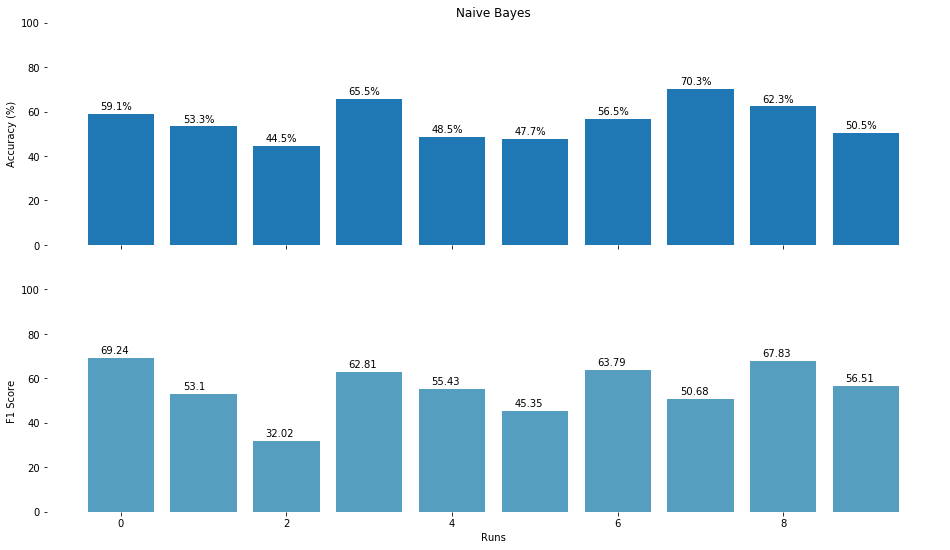

In [41]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Naive Bayes')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()

In [159]:
train_date_begin = '2014-01-27'
test_date_begin = '2014-12-04'
train_date_end = '2015-12-31'
test_date_end = '2015-04-09'

X_train, X_test = pd.concat([X.loc['2014-01-27':'2014-12-03'], X.loc['2015-04-10':'2015-12-31']]), X.loc['2014-12-04':'2015-04-09']
y_train, y_test = pd.concat([y.loc['2014-01-27':'2014-12-04'], y.loc['2015-04-09':'2015-12-31']]), y.loc['2014-12-04':'2015-04-09']

# Graph most influential words:

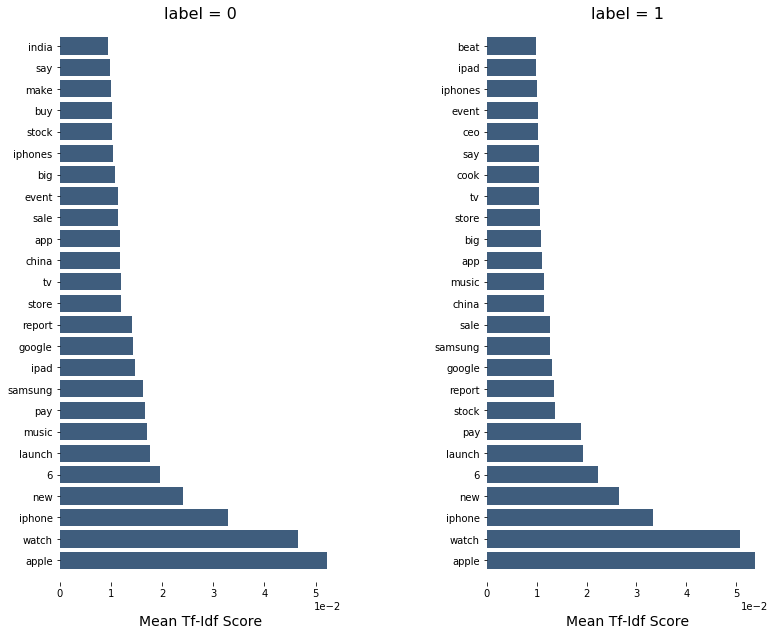

In [13]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

# model.named_steps['features'].transformer_list[1][1].named_steps['vec']
Xtr = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].fit_transform(X['text'])
features = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].get_feature_names()
feats = top_feats_by_class(Xtr, y, features)

plot_tfidf_classfeats_h(feats)

# Plot ROC Curve along with other stats

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
from matplotlib import pyplot

def evaluate(classifier):
    predicted = classifier.predict(X_test)
    if isinstance(classifier.steps[1][1], LinearSVC):
        probabilities = np.array(classifier.decision_function(X_test))
        scores = probabilities
    else:
        probabilities = np.array(classifier.predict_proba(X_test))
        scores = probabilities[:, 1]  # NEW

    testing_category_array = np.array(y_test)  # NEW
    pos_idx = np.where(testing_category_array == 1)
    predicted_true_binary = np.zeros(testing_category_array.shape)
    predicted_true_binary[pos_idx] = 1
    fpr, tpr, thresholds = roc_curve(predicted_true_binary, scores)
    auc = roc_auc_score(predicted_true_binary, scores)

    mean_acc = np.mean(predicted == y_test)
    report = classification_report(y_test, predicted)

    return fpr, tpr, auc, mean_acc, report

fpr, tpr, auc, mean_acc, report = evaluate(model)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [37]:
feats = FeatureUnion([
              ('numeric_features', Pipeline([
                  ('selector', get_numeric_data)
              ])),
                ('text_features', Pipeline([
                   ('selector', get_text_data),
                   ('vec',  vect)
               ]))
         ])

data = feats.fit_transform(X_train)

In [ ]:
# indx = np.where(abs(tsvd.components_[0]) <= 0.01)
indx = [0, 1, 2, 3, 12, 20, 21, 25, 26, 29, 30, 31, 32, 42, 46, 47, 55, 63]
X_train.drop(X_train.columns[indx], axis=1)

In [ ]:
tsvd.components_[0]

In [122]:
np.where(abs(tsvd.components_[0]) <= 0.01)

(array([ 0,  1,  2,  3, 12, 20, 21, 25, 26, 29, 30, 31, 32, 42, 46, 47, 55,
        63], dtype=int64),)

In [38]:
from mlxtend.plotting import plot_decision_regions
from sklearn.manifold import TSNE

tsvd = TruncatedSVD(n_components=2)
# tsvd = TSNE(n_components=2, verbose=1)
pca = tsvd.fit(data)
pca_2d = tsvd.transform(data)

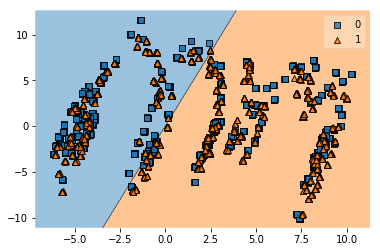

In [39]:
svmClassifier_2d =   model.named_steps['clf'].fit(pca_2d, y_train)


plot_decision_regions(X=pca_2d, y=y_train.values, clf=svmClassifier_2d)